In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


In [3]:
pdb='/Users/Kerenattiku/Desktop/AggR_only/Agg_prod_stripped.pdb'
trajectory='/Users/Kerenattiku/Desktop/AggR_only/Agg_only_stripped.xtc'
outdir='/Users/Kerenattiku/Desktop/AggR_only/outdir'

if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trajectory:",trajectory)

outdir: /Users/Kerenattiku/Desktop/AggR_only/outdir
pdb: /Users/Kerenattiku/Desktop/AggR_only/Agg_prod_stripped.pdb
trajectory: /Users/Kerenattiku/Desktop/AggR_only/Agg_only_stripped.xtc


In [4]:
trj = md.load(trajectory, top=pdb,stride=5)
trj.center_coordinates()
trj.superpose(trj[0])
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [5]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 4391

Number of residues: 265

Number of frames: 6000

Starting frame: 0

Last frame: 6000

sequence:  [MET1, LYS2, LEU3, LYS4, GLN5, ASN6, ILE7, GLU8, LYS9, GLU10, ILE11, ILE12, LYS13, ILE14, ASN15, ASN16, ILE17, ARG18, ILE19, HIS20, GLN21, TYR22, THR23, VAL24, LEU25, TYR26, THR27, SER28, ASN29, CYS30, THR31, ILE32, ASP33, VAL34, TYR35, THR36, LYS37, GLU38, GLY39, SER40, ASN41, THR42, TYR43, LEU44, ARG45, ASN46, GLU47, LEU48, ILE49, PHE50, LEU51, GLU52, ARG53, GLY54, ILE55, ASN56, ILE57, SER58, VAL59, ARG60, LEU61, GLN62, LYS63, LYS64, LYS65, SER66, THR67, VAL68, ASN69, PRO70, PHE71, ILE72, ALA73, ILE74, ARG75, LEU76, SER77, SER78, ASP79, THR80, LEU81, ARG82, ARG83, LEU84, LYS85, ASP86, ALA87, LEU88, MET89, ILE90, ILE91, TYR92, GLY93, ILE94, SER95, LYS96, VAL97, ASP98, ALA99, CYS100, SER101, CYS102, PRO103, ASN104, TRP105, SER106, LYS107, GLY108, ILE109, ILE110, VAL111, ALA112, ASP113, ALA114, ASP115, ASP116, SER117, VAL118, LEU119, ASP120, THR121, 

In [6]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id
#residue_num

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [7]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'C', 'C', ..., 'C', 'C', 'C'],
       ['C', 'C', 'C', ..., 'C', 'C', 'C'],
       ['C', 'C', 'C', ..., 'C', 'C', 'C'],
       ...,
       ['C', 'E', 'C', ..., 'H', 'C', 'C'],
       ['C', 'E', 'C', ..., 'H', 'C', 'C'],
       ['C', 'E', 'C', ..., 'H', 'C', 'C']], dtype='<U2')

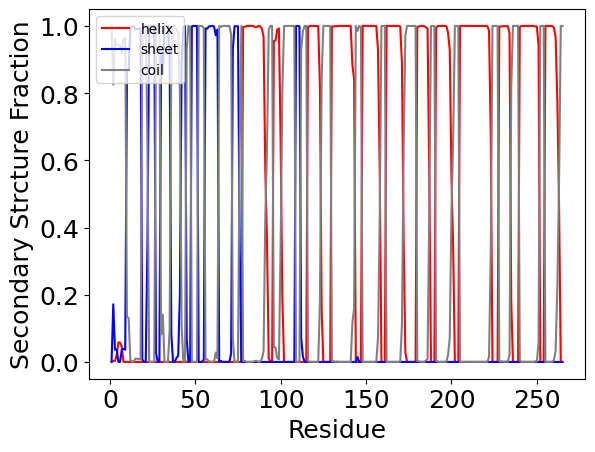

In [8]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspC=np.copy(dssp)

 dsspH[dsspH=='H']=1                                                                                    
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                     
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspH) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 

 dsspC[dsspC=='H']=0
 dsspC[dsspC=='E']=0
 dsspC[dsspC=='C']=1
 dsspC[dsspC=='NA']=0
 dsspC=dsspC.astype(int)
 TotalC=np.sum(dsspC,axis=1) 
 Cprop=np.sum(dsspC,axis=0).astype(float)/len(dsspC) 
 return Hprop, Eprop, Cprop

Hprop,Eprop,Cprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')
plt.plot(residue_num, Cprop,c='grey',label='coil')


plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


SS: H [ 78  79  80  81  82  83  84  85  86  87  96  97  98  99 116 117 118 119
 120 121 122 130 131 132 133 134 135 136 137 138 139 140 141 148 149 150
 151 152 153 154 155 156 157 162 163 164 165 166 167 168 169 170 180 181
 182 183 184 185 186 191 192 193 194 195 196 197 198 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 228 229 230 231 232
 233 234 240 241 242 243 244 245 246 247 248 249 250 251 255 256 257 258
 259 260 261]
SS: E [ 12  13  14  15  16  17  18  23  24  25  26  32  33  34  35  43  44  48
  49  50  51  56  57  58  59  60  61  62  63  72  73  74  75 109 110 111]
SS: I []
SS: G []
SS: B []
SS: T [ 53  54 188 202 236]
SS: S [ 21  29  46  64  68 176 189 226 252 253]
SS:   [  1  19  27  36  40  52  55  69  71  77  94  95 103 107 112 113 114 115
 125 126 159 160 161 177 178 179 190 204 225 227 237 239 254 264 265]


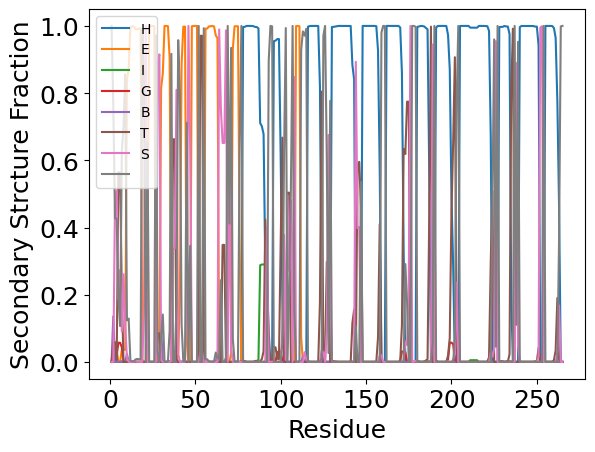

In [9]:
dssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1                                                                                      
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


SS: H [ 78  79  80  81  82  83  84  85  86  87  96  97  98  99 116 117 118 119
 120 121 122 130 131 132 133 134 135 136 137 138 139 140 141 148 149 150
 151 152 153 154 155 156 157 162 163 164 165 166 167 168 169 170 180 181
 182 183 184 185 186 191 192 193 194 195 196 197 198 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 228 229 230 231 232
 233 234 240 241 242 243 244 245 246 247 248 249 250 251 255 256 257 258
 259 260 261]
SS: E [ 12  13  14  15  16  17  18  23  24  25  26  32  33  34  35  43  44  48
  49  50  51  56  57  58  59  60  61  62  63  72  73  74  75 109 110 111]
SS: I []
SS: G []
SS: B []
SS: T [ 53  54 188 202 236]
SS: S [ 21  29  46  64  68 176 189 226 252 253]
SS:   [  1  19  27  36  40  52  55  69  71  77  94  95 103 107 112 113 114 115
 125 126 159 160 161 177 178 179 190 204 225 227 237 239 254 264 265]


(70.0, 77.0)

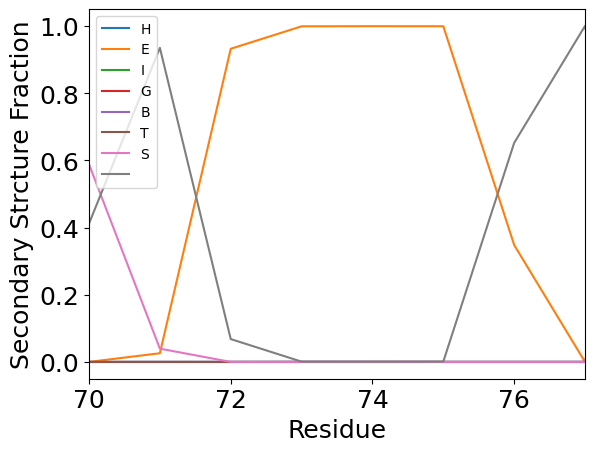

In [10]:
#another way to confirm that the residues of interest above exist only in the alpha 4 helix linker region of the DBD 
ssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1                                                                                      
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(70, 77)

In [60]:
#Find all the frames where a given residue is H or E
residue_number=75
array_index=residue_number-0
print(np.asarray(residue_num)[array_index])
helix_frames=np.where(dssp[:,array_index]=='H')[0]
beta_frames=np.where(dssp[:,array_index]=='E')[0]

print("Residue %s"%np.asarray(residue_num)[array_index])
print("helix frames:",len(helix_frames),helix_frames)
print("beta frames:",len(beta_frames),beta_frames)

76
Residue 76
helix frames: 0 []
beta frames: 2089 [  34   75  101 ... 5989 5997 5998]


In [61]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [62]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices = indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [51]:
sequence

' [MET1, LYS2, LEU3, LYS4, GLN5, ASN6, ILE7, GLU8, LYS9, GLU10, ILE11, ILE12, LYS13, ILE14, ASN15, ASN16, ILE17, ARG18, ILE19, HIS20, GLN21, TYR22, THR23, VAL24, LEU25, TYR26, THR27, SER28, ASN29, CYS30, THR31, ILE32, ASP33, VAL34, TYR35, THR36, LYS37, GLU38, GLY39, SER40, ASN41, THR42, TYR43, LEU44, ARG45, ASN46, GLU47, LEU48, ILE49, PHE50, LEU51, GLU52, ARG53, GLY54, ILE55, ASN56, ILE57, SER58, VAL59, ARG60, LEU61, GLN62, LYS63, LYS64, LYS65, SER66, THR67, VAL68, ASN69, PRO70, PHE71, ILE72, ALA73, ILE74, ARG75, LEU76, SER77, SER78, ASP79, THR80, LEU81, ARG82, ARG83, LEU84, LYS85, ASP86, ALA87, LEU88, MET89, ILE90, ILE91, TYR92, GLY93, ILE94, SER95, LYS96, VAL97, ASP98, ALA99, CYS100, SER101, CYS102, PRO103, ASN104, TRP105, SER106, LYS107, GLY108, ILE109, ILE110, VAL111, ALA112, ASP113, ALA114, ASP115, ASP116, SER117, VAL118, LEU119, ASP120, THR121, PHE122, LYS123, SER124, ILE125, ASP126, HIS127, ASN128, ASP129, ASP130, SER131, ARG132, ILE133, THR134, SER135, ASP136, LEU137, ILE138, T

In [52]:
#Heres a function to plot a phi/psi ramachandran plot: 

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




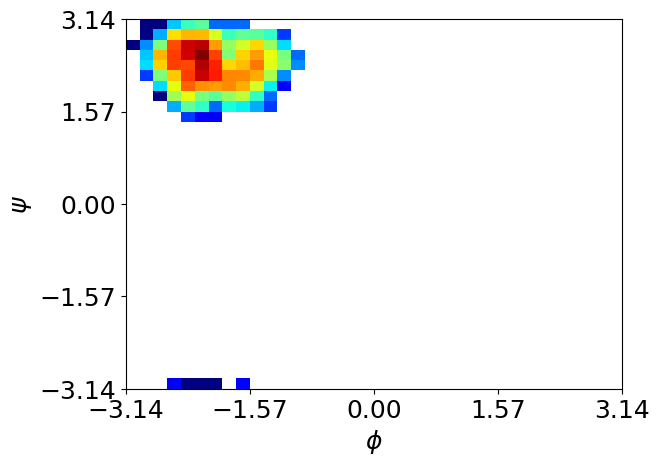

In [53]:
# Analyzing phi/psi angles for residue of interest and compare to apo residue conformations. Give insight into change in backbone. 
plot_phipsi(75)

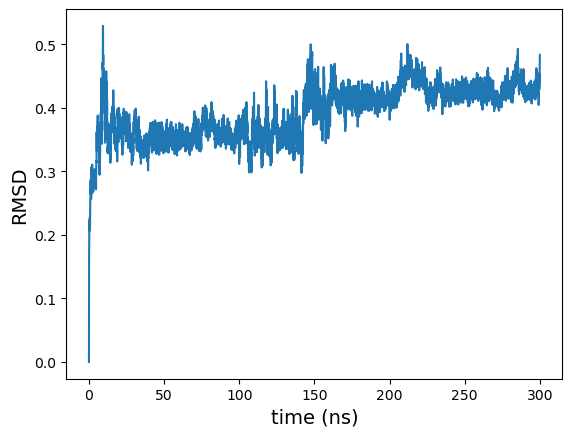

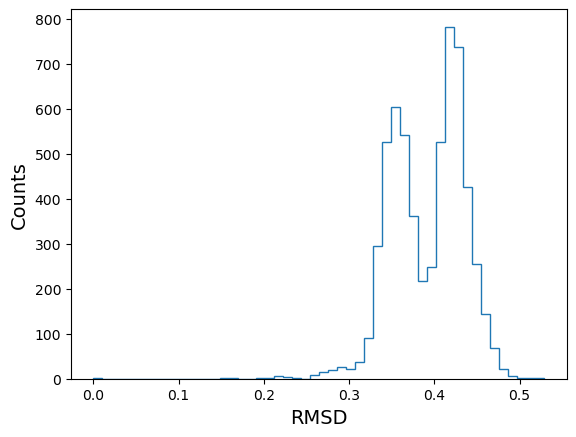

In [63]:
#Lets Calculate the RMSD and make a histogram from the starting structure. 
# Compare RMSD to apo structure to determine effect of ligand binding on structure variability over time. 
time=np.linspace(0,300,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time (ns)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

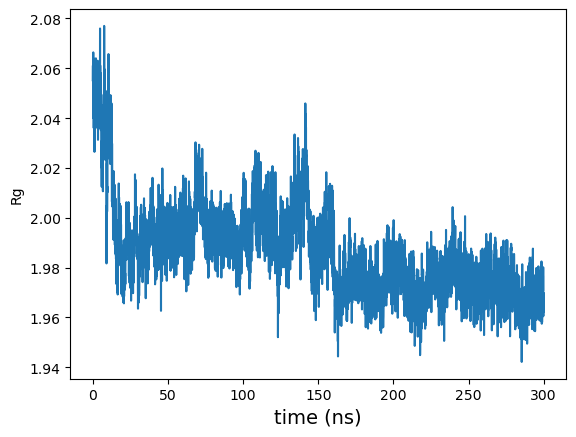

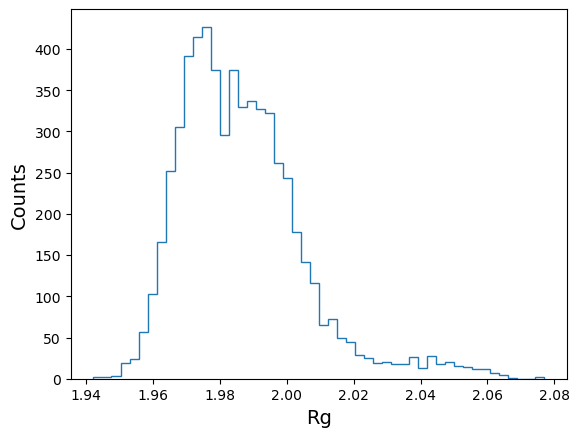

In [64]:
#Lets calculate the radius of gyration and make a histogram. 
#Compare to apo structure to evaluate the impact of ligand binding on protein expansition and compaction. 
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.ylabel('Rg');
plt.xlabel('time (ns)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()

In [65]:
#Lets identify subtantially populated hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))
    

LEU3-N -- LYS9-O
GLN5-N -- GLN5-OE1
ILE7-N -- LYS4-O
GLU8-N -- LYS4-O
LYS9-N -- GLU8-OE2
GLU10-N -- LYS63-O
ILE11-N -- MET1-O
ILE12-N -- LEU61-O
ILE14-N -- VAL59-O
ASN15-N -- PHE251-O
ASN15-ND2 -- PHE251-O
ASN16-N -- SER58-OG
ASN16-ND2 -- HIS250-O
ILE17-N -- ILE57-O
ILE19-N -- ILE55-O
HIS20-N -- ARG18-O
HIS20-NE2 -- GLU171-OE1
HIS20-NE2 -- GLU171-OE2
GLN21-NE2 -- LEU76-O
THR23-N -- LEU51-O
VAL24-N -- ILE74-O
LEU25-N -- ILE49-O
TYR26-N -- ILE72-O
THR27-N -- GLU47-O
SER28-N -- TYR26-O
ASN29-N -- SER28-OG
ASN29-N -- PRO70-O
ASN29-ND2 -- LYS65-O
ASN29-ND2 -- VAL68-O
ASN29-ND2 -- ASN69-O
CYS30-N -- PRO70-O
THR31-N -- GLN62-O
ILE32-N -- LEU44-O
ASP33-N -- ARG60-O
VAL34-N -- THR42-O
TYR35-N -- SER58-O
THR36-N -- SER40-O
THR36-N -- ASN41-OD1
GLU38-N -- THR36-OG1
GLU38-N -- GLU38-OE1
GLU38-N -- GLU38-OE2
GLY39-N -- THR36-OG1
GLY39-N -- THR36-O
SER40-N -- THR36-OG1
SER40-N -- GLU38-OE1
SER40-N -- GLU38-OE2
ASN41-N -- GLY39-O
ASN41-ND2 -- ASP33-OD1
ASN41-ND2 -- THR36-O
ASN41-ND2 -- VAL34-O
THR42-

In [66]:
for hbond in hbonds:
 donor = top.atom(hbond[0])
 acc = top.atom(hbond[2])
 print(hbond,donor,acc)

[ 41  42 168] LEU3-N LYS9-O
[82 83 93] GLN5-N GLN5-OE1
[113 114  81] ILE7-N LYS4-O
[132 133  81] GLU8-N LYS4-O
[147 148 144] LYS9-N GLU8-OE2
[ 169  170 1083] GLU10-N LYS63-O
[184 185  18] ILE11-N MET1-O
[ 203  204 1044] ILE12-N LEU61-O
[ 244  245 1001] ILE14-N VAL59-O
[ 263  264 4152] ASN15-N PHE251-O
[ 272  274 4152] ASN15-ND2 PHE251-O
[277 278 982] ASN16-N SER58-OG
[ 286  288 4132] ASN16-ND2 HIS250-O
[291 292 974] ILE17-N ILE57-O
[334 335 941] ILE19-N ILE55-O
[353 354 333] HIS20-N ARG18-O
[ 364  365 2807] HIS20-NE2 GLU171-OE1
[ 364  365 2808] HIS20-NE2 GLU171-OE2
[ 382  384 1307] GLN21-NE2 LEU76-O
[408 409 876] THR23-N LEU51-O
[ 422  423 1264] VAL24-N ILE74-O
[438 439 837] LEU25-N ILE49-O
[ 457  458 1235] TYR26-N ILE72-O
[478 479 799] THR27-N GLU47-O
[492 493 477] SER28-N TYR26-O
[503 504 499] ASN29-N SER28-OG
[ 503  504 1196] ASN29-N PRO70-O
[ 512  513 1127] ASN29-ND2 LYS65-O
[ 512  514 1168] ASN29-ND2 VAL68-O
[ 512  514 1182] ASN29-ND2 ASN69-O
[ 517  518 1196] CYS30-N PRO70-O
[ 528

In [67]:
import mdtraj as md

# Assuming `trj` is your trajectory object
hbonds = md.baker_hubbard(trj, periodic=False)

# Define a function to label the hydrogen bonds with their indices
label_with_index = lambda hbond, index: '%d: %s -- %s' % (index, trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))

# Loop through each hbond and print with the index
for index, hbond in enumerate(hbonds):
    print(label_with_index(hbond, index))


0: LEU3-N -- LYS9-O
1: GLN5-N -- GLN5-OE1
2: ILE7-N -- LYS4-O
3: GLU8-N -- LYS4-O
4: LYS9-N -- GLU8-OE2
5: GLU10-N -- LYS63-O
6: ILE11-N -- MET1-O
7: ILE12-N -- LEU61-O
8: ILE14-N -- VAL59-O
9: ASN15-N -- PHE251-O
10: ASN15-ND2 -- PHE251-O
11: ASN16-N -- SER58-OG
12: ASN16-ND2 -- HIS250-O
13: ILE17-N -- ILE57-O
14: ILE19-N -- ILE55-O
15: HIS20-N -- ARG18-O
16: HIS20-NE2 -- GLU171-OE1
17: HIS20-NE2 -- GLU171-OE2
18: GLN21-NE2 -- LEU76-O
19: THR23-N -- LEU51-O
20: VAL24-N -- ILE74-O
21: LEU25-N -- ILE49-O
22: TYR26-N -- ILE72-O
23: THR27-N -- GLU47-O
24: SER28-N -- TYR26-O
25: ASN29-N -- SER28-OG
26: ASN29-N -- PRO70-O
27: ASN29-ND2 -- LYS65-O
28: ASN29-ND2 -- VAL68-O
29: ASN29-ND2 -- ASN69-O
30: CYS30-N -- PRO70-O
31: THR31-N -- GLN62-O
32: ILE32-N -- LEU44-O
33: ASP33-N -- ARG60-O
34: VAL34-N -- THR42-O
35: TYR35-N -- SER58-O
36: THR36-N -- SER40-O
37: THR36-N -- ASN41-OD1
38: GLU38-N -- THR36-OG1
39: GLU38-N -- GLU38-OE1
40: GLU38-N -- GLU38-OE2
41: GLY39-N -- THR36-OG1
42: GLY39-N --

[353 354 333] HIS20-N ARG18-O
[ 364  365 2807] HIS20-NE2 GLU171-OE1
[ 364  365 2808] HIS20-NE2 GLU171-OE2


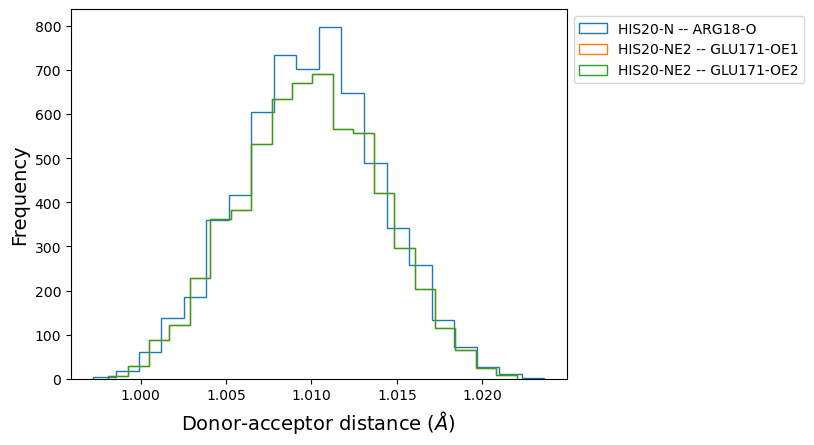

In [72]:
#Which residues does His 20 form hydrogen bonds with in the apo stucture
import mdtraj as md
import matplotlib.pyplot as plt

# Assuming `trj` is your trajectory object and `top` is its topology
hbonds = md.baker_hubbard(trj, periodic=False)

# List of specific Hbond indices you want to plot
hbond_indices = [15, 16, 17]  # Example indices

# Define a function to label the hydrogen bonds
label = lambda hbond: '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))

# Initialize the plot
plt.figure()

# Loop over the list of specific Hbond indices
for Hbond_index in hbond_indices:
    hbond = hbonds[Hbond_index]
    donor = trj.topology.atom(hbond[0])
    acc = trj.topology.atom(hbond[2])
    
    print(hbond, donor, acc)
    
    da_distance = md.compute_distances(trj, [[hbond[0], hbond[1]]], periodic=False)
    plt.hist(da_distance*10, histtype='step', bins=20, label=label(hbond))

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.ylabel('Frequency', size=14)
plt.xlabel('Donor-acceptor distance ($\AA$)', size=14)
plt.show()


[1278 1279  381] ARG75-NE GLN21-OE1
[1281 1282  381] ARG75-NH1 GLN21-OE1
[1281 1283 3687] ARG75-NH1 ASP223-OD1
[1281 1283 3688] ARG75-NH1 ASP223-OD2
[1284 1285 3687] ARG75-NH2 ASP223-OD1
[1284 1285 3688] ARG75-NH2 ASP223-OD2
[1284 1286 3687] ARG75-NH2 ASP223-OD1
[1284 1286 3688] ARG75-NH2 ASP223-OD2


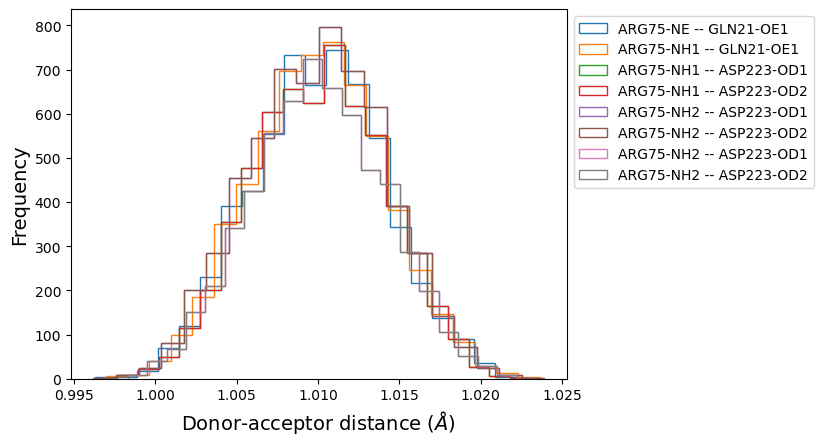

In [73]:
#loopping over every residue to find residues that form hydrogen bonds the ligand
import mdtraj as md
import matplotlib.pyplot as plt

# Assuming `trj` is your trajectory object and `top` is its topology
hbonds = md.baker_hubbard(trj, periodic=False)

# List of specific Hbond indices you want to plot
hbond_indices = [109, 110, 111, 112, 113, 114, 115, 116]  # Example indices

# Define a function to label the hydrogen bonds
label = lambda hbond: '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))

# Initialize the plot
plt.figure()

# Loop over the list of specific Hbond indices
for Hbond_index in hbond_indices:
    hbond = hbonds[Hbond_index]
    donor = trj.topology.atom(hbond[0])
    acc = trj.topology.atom(hbond[2])
    
    print(hbond, donor, acc)
    
    da_distance = md.compute_distances(trj, [[hbond[0], hbond[1]]], periodic=False)
    plt.hist(da_distance*10, histtype='step', bins=20, label=label(hbond))

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.ylabel('Frequency', size=14)
plt.xlabel('Donor-acceptor distance ($\AA$)', size=14)
plt.show()


(6000, 2)


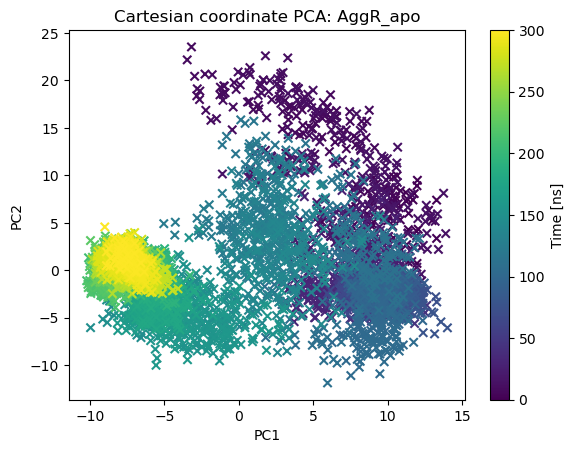

In [74]:
#identification of structural trends acroos the frames over time
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)
#We Can plot eaceh frame as a function of the values of each PC(principal component): PC1 and PC2
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: AggR_apo')
cbar = plt.colorbar()
cbar.set_label('Time [ns]')

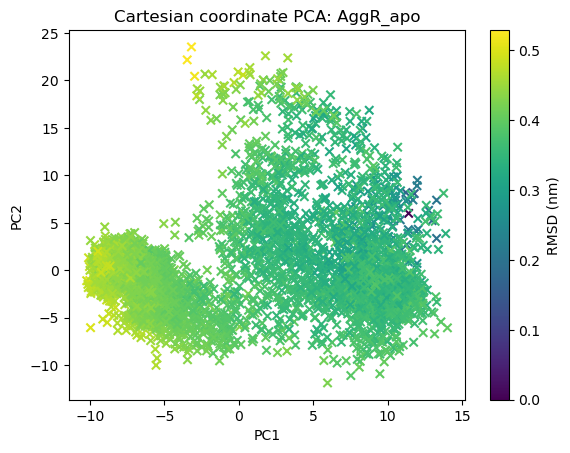

In [75]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: AggR_apo')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

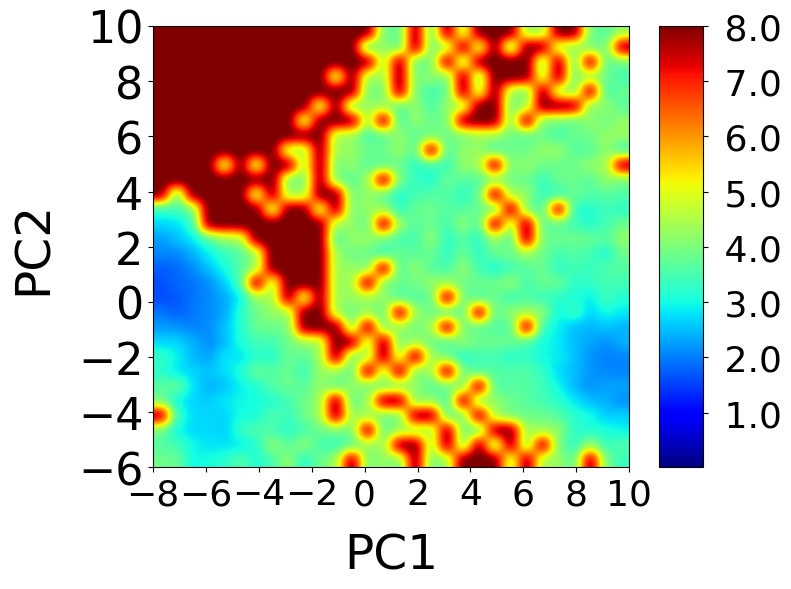

In [80]:
###Free Energy Plot of PC1 vs. PC2

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -6, 10, -8, 10)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-8,10)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

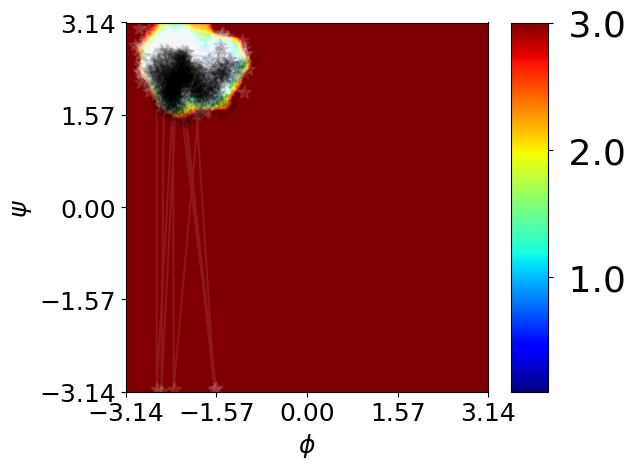

In [81]:
res = 75
phis = dihedral_dict['phi'][res]
psis = dihedral_dict['psi'][res]
chi1s = dihedral_dict['chi1'][res]

basin1_chi = np.where((chi1s < 1.57 ) & (chi1s > 0))
basin2_chi = np.where((np.abs(chi1s) < np.pi ) &  (np.abs(chi1s)> np.pi - 0.5))
def plot_phipsi_with_FES(res, frames1, frames2):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()
 plt.plot(dihedral_dict['phi'][res][frames1], dihedral_dict['psi'][res][frames1], color="white", marker="*", markersize=10, alpha = 0.1)
 plt.plot( dihedral_dict['phi'][res][frames2], dihedral_dict['psi'][res][frames2], color="black", marker="*", markersize=10, alpha = 0.1)
 plt.xticks([-3.14,-1.57,0,1.57,3.14],fontsize=35)
 plt.yticks([-3.14,-1.57,0,1.57,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=3.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return
plot_phipsi_with_FES(75, basin1_chi, basin2_chi)

In [82]:
def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], density=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters

Text(0.5, 1.0, 'structural changes in unbound AggR')

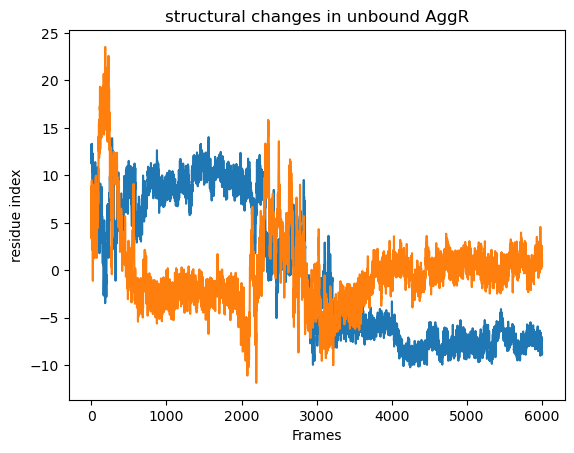

In [137]:
##structural differences observed about different conformations that exist within unbound AggR
plt.plot(PC1)
plt.plot(PC2)
plt.ylabel("residue index")
plt.xlabel("Frames")
plt.title('structural changes in unbound AggR')


In [96]:
#three different basins were observed to be present in the cartesian and free energy plots and this is also observed in
# the 
state1 = np.where((PC2 < 10) & (PC2 > 2.5))[0] 
state2 = np.where((PC2 < 2.5) & (PC2 > -2.5))[0] 
state3 = np.where((PC2 < 2.5) & (PC2 > -2.5))[0] 
state1_reduced = state1[::15]
state2_reduced = state2[::30]
state3_reduced = state3[::50]

In [97]:
print(state1_reduced)
print(state2_reduced)
print(state3_reduced)

[   0   16   37   56   71   87  264  286  345  360  375  392  407  445
  557  572 2146 2257 2287 2305 2339 2381 2397 2412 2427 2468 2483 2506
 2525 2543 2583 2600 2616 2640 2662 2680 2738 2813 4124 4733 5572 5710
 5770 5977]
[  11  424  467  502  533  587  646  695  725  771  838  959 1014 1105
 1152 1190 1236 1273 1309 1356 1407 1461 1547 1606 1655 1686 1724 1763
 1821 1875 1931 2121 2172 2235 2378 2522 2597 2719 2791 2832 2934 3008
 3332 3521 3615 3664 3695 3734 3764 3794 3824 3854 3889 3919 3949 3982
 4014 4045 4075 4105 4137 4167 4197 4228 4258 4294 4326 4357 4391 4421
 4451 4488 4518 4549 4579 4610 4640 4670 4700 4737 4770 4800 4830 4860
 4890 4920 4950 4984 5014 5045 5075 5105 5135 5166 5198 5228 5259 5289
 5319 5349 5379 5409 5439 5469 5499 5529 5559 5600 5630 5664 5694 5736
 5773 5804 5834 5864 5894 5926 5964 5999]
[  11  457  513  587  680  735  838 1001 1120 1190 1263 1326 1407 1509
 1621 1686 1750 1839 1931 2158 2251 2522 2707 2802 2934 3106 3570 3664
 3723 3774 3824 3879 39

In [98]:
np.argmax(rg)

151

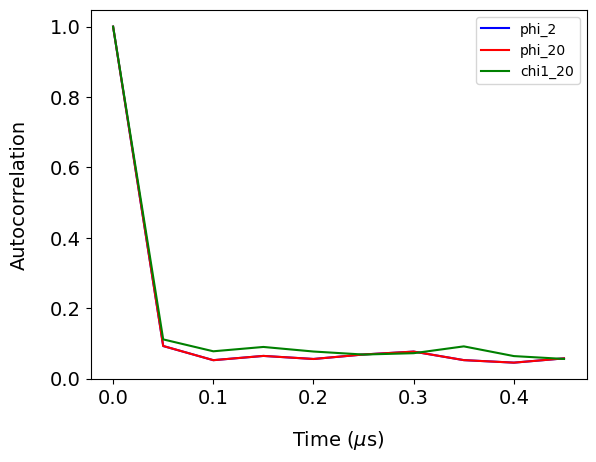

In [99]:
def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

# Define time in microseconds
time = np.linspace(0, 300, trj.n_frames)

# Define the lags for autocorrelation analysis
lags = range(10)

# Calculate autocorrelation for specific dihedral angles
phi2_acf = autocorr1(dihedral_dict['phi'][20], lags)
phi20_acf = autocorr1(dihedral_dict['phi'][20], lags)
chi20_acf = autocorr1(dihedral_dict['chi1'][20], lags)

# Plot autocorrelation functions
plt.plot(time[lags], phi2_acf, color='b', label='phi_2')
plt.plot(time[lags], phi20_acf, color='r', label='phi_20')
plt.plot(time[lags], chi20_acf, color='g', label='chi1_20')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()


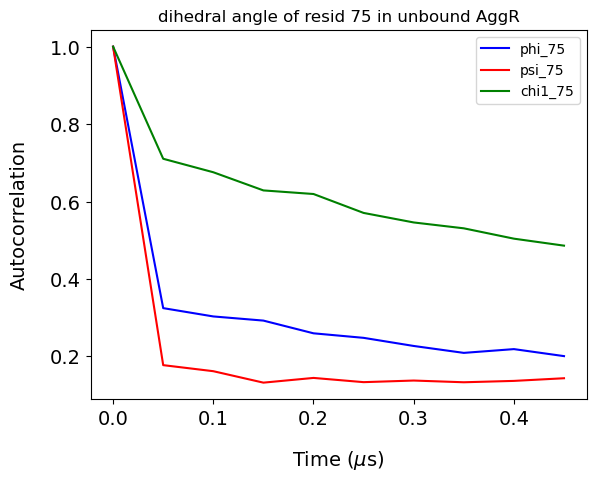

In [139]:
###### 2.) Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,300,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi75_acf=autocorr1(dihedral_dict['phi'][75],lags) #acf = autocorrelation fun
psi75_acf=autocorr1(dihedral_dict['psi'][75],lags)
chi75_acf=autocorr1(dihedral_dict['chi1'][75],lags)

plt.plot(time[lags],phi75_acf,color='b',label='phi_75')
plt.plot(time[lags],psi75_acf,color='r',label='psi_75')
plt.plot(time[lags],chi75_acf,color='g',label='chi1_75')

plt.legend()
plt.title('dihedral angle of resid 75 in unbound AggR')
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()


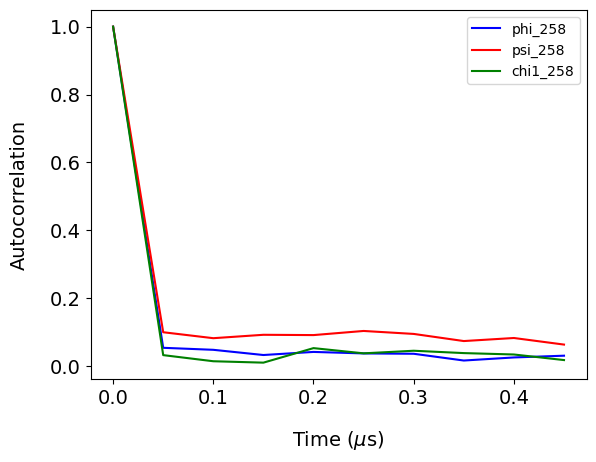

In [103]:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,300,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi258_acf=autocorr1(dihedral_dict['phi'][258],lags) #acf = autocorrelation fun
psi258_acf=autocorr1(dihedral_dict['psi'][258],lags)
chi258_acf=autocorr1(dihedral_dict['chi1'][258],lags)

plt.plot(time[lags],phi258_acf,color='b',label='phi_258')
plt.plot(time[lags],psi258_acf,color='r',label='psi_258')
plt.plot(time[lags],chi258_acf,color='g',label='chi1_258')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

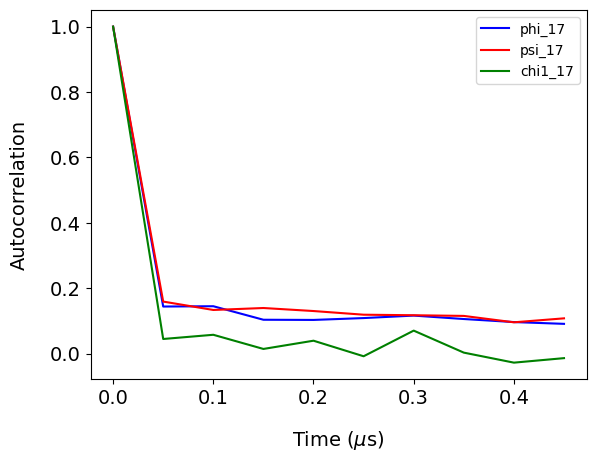

In [104]:
###### 2.) Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,300,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi17_acf=autocorr1(dihedral_dict['phi'][17],lags) #acf = autocorrelation fun
psi17_acf=autocorr1(dihedral_dict['psi'][17],lags)
chi17_acf=autocorr1(dihedral_dict['chi1'][17],lags)

plt.plot(time[lags],phi17_acf,color='b',label='phi_17')
plt.plot(time[lags],psi17_acf,color='r',label='psi_17')
plt.plot(time[lags],chi17_acf,color='g',label='chi1_17')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

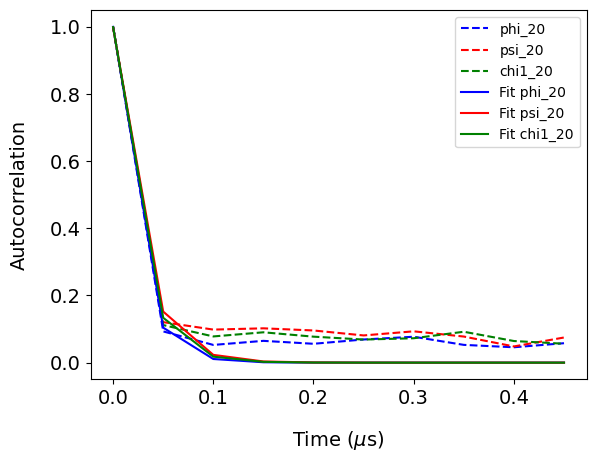

Correlation times:
phi_20: 0.02210864590402139
psi_20: 0.026574646743991865
chi1_20: 0.024848443199779035


In [105]:
#2a Can you calculate/ fit the correlation times
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def exponential_decay(t, tau, A):
    """Exponential decay function"""
    return A * np.exp(-t / tau)

def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

# Define time in microseconds
time = np.linspace(0, 300, trj.n_frames)

# Define the lags for autocorrelation analysis
lags = range(10)

# Calculate autocorrelation for specific dihedral angles
phi20_acf = autocorr1(dihedral_dict['phi'][20], lags)
psi20_acf = autocorr1(dihedral_dict['psi'][20], lags)
chi20_acf = autocorr1(dihedral_dict['chi1'][20], lags)

# Fit exponential decay curve to autocorrelation data
popt_phi20, pcov_phi20 = curve_fit(exponential_decay, time[lags], phi20_acf)
popt_psi20, pcov_psi20 = curve_fit(exponential_decay, time[lags], psi20_acf)
popt_chi20, pcov_chi20 = curve_fit(exponential_decay, time[lags], chi20_acf)

# Plot autocorrelation functions against lag time
plt.plot(time[lags], phi20_acf, 'b--', label='phi_20')
plt.plot(time[lags], psi20_acf, 'r--', label='psi_20')
plt.plot(time[lags], chi20_acf, 'g--', label='chi1_20')

# Plot fitted curves
plt.plot(time[lags], exponential_decay(time[lags], *popt_phi20), 'b-', label='Fit phi_20')
plt.plot(time[lags], exponential_decay(time[lags], *popt_psi20), 'r-', label='Fit psi_20')
plt.plot(time[lags], exponential_decay(time[lags], *popt_chi20), 'g-', label='Fit chi1_20')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

# Extract correlation times from fitted parameters
tau_phi20 = popt_phi20[0]
tau_psi20 = popt_psi20[0]
tau_chi20 = popt_chi20[0]

print("Correlation times:")
print("phi_20:", tau_phi20)
print("psi_20:", tau_psi20)
print("chi1_20:", tau_chi20)


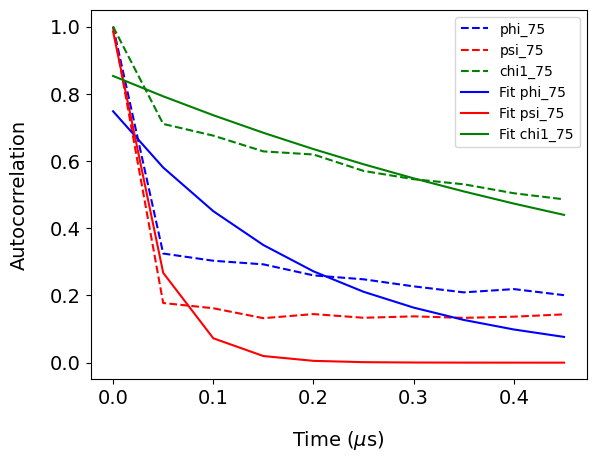

Correlation times:
phi_75: 0.1974977939356792
psi_75: 0.038326602706476705
chi1_75: 0.6791004390080335


In [106]:
# Calculate autocorrelation for specific dihedral angles
phi75_acf = autocorr1(dihedral_dict['phi'][75], lags)
psi75_acf = autocorr1(dihedral_dict['psi'][75], lags)
chi75_acf = autocorr1(dihedral_dict['chi1'][75], lags)

# Fit exponential decay curve to autocorrelation data
popt_phi75, pcov_phi75 = curve_fit(exponential_decay, time[lags], phi75_acf)
popt_psi75, pcov_psi75 = curve_fit(exponential_decay, time[lags], psi75_acf)
popt_chi75, pcov_chi75 = curve_fit(exponential_decay, time[lags], chi75_acf)

# Plot autocorrelation functions against lag time
plt.plot(time[lags], phi75_acf, 'b--', label='phi_75')
plt.plot(time[lags], psi75_acf, 'r--', label='psi_75')
plt.plot(time[lags], chi75_acf, 'g--', label='chi1_75')

# Plot fitted curves
plt.plot(time[lags], exponential_decay(time[lags], *popt_phi75), 'b-', label='Fit phi_75')
plt.plot(time[lags], exponential_decay(time[lags], *popt_psi75), 'r-', label='Fit psi_75')
plt.plot(time[lags], exponential_decay(time[lags], *popt_chi75), 'g-', label='Fit chi1_75')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

# Extract correlation times from fitted parameters
tau_phi75 = popt_phi75[0]
tau_psi75 = popt_psi75[0]
tau_chi75 = popt_chi75[0]

print("Correlation times:")
print("phi_75:", tau_phi75)
print("psi_75:", tau_psi75)
print("chi1_75:", tau_chi75)


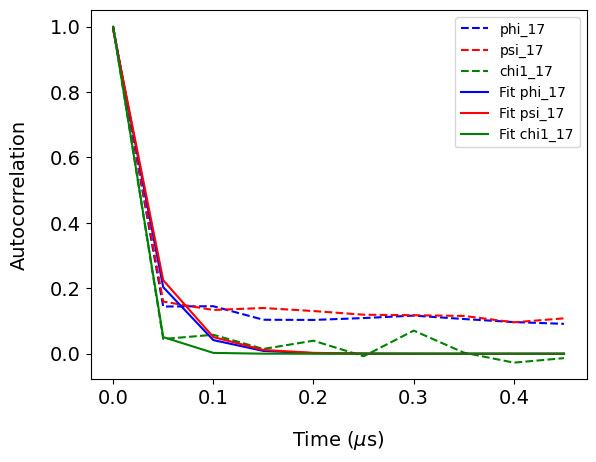

Correlation times:
phi_17: 0.03154567706490327
psi_17: 0.033714251380921545
chi1_17: 0.016787030215998297


In [107]:
# Calculate autocorrelation for specific dihedral angles
phi17_acf = autocorr1(dihedral_dict['phi'][17], lags)
psi17_acf = autocorr1(dihedral_dict['psi'][17], lags)
chi17_acf = autocorr1(dihedral_dict['chi1'][17], lags)

# Fit exponential decay curve to autocorrelation data
popt_phi17, pcov_phi17 = curve_fit(exponential_decay, time[lags], phi17_acf)
popt_psi17, pcov_psi17 = curve_fit(exponential_decay, time[lags], psi17_acf)
popt_chi17, pcov_chi17 = curve_fit(exponential_decay, time[lags], chi17_acf)

# Plot autocorrelation functions against lag time
plt.plot(time[lags], phi17_acf, 'b--', label='phi_17')
plt.plot(time[lags], psi17_acf, 'r--', label='psi_17')
plt.plot(time[lags], chi17_acf, 'g--', label='chi1_17')

# Plot fitted curves
plt.plot(time[lags], exponential_decay(time[lags], *popt_phi17), 'b-', label='Fit phi_17')
plt.plot(time[lags], exponential_decay(time[lags], *popt_psi17), 'r-', label='Fit psi_17')
plt.plot(time[lags], exponential_decay(time[lags], *popt_chi17), 'g-', label='Fit chi1_17')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

# Extract correlation times from fitted parameters
tau_phi17 = popt_phi17[0]
tau_psi17 = popt_psi17[0]
tau_chi17 = popt_chi17[0]

print("Correlation times:")
print("phi_17:", tau_phi17)
print("psi_17:", tau_psi17)
print("chi1_17:", tau_chi17)


/var/folders/np/p_8hx6w53z9gtvwkrthry9x00000gn/T/ipykernel_8319/2996420271.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_phi258, pcov_phi258 = curve_fit(exponential_decay, time[lags], phi258_acf)


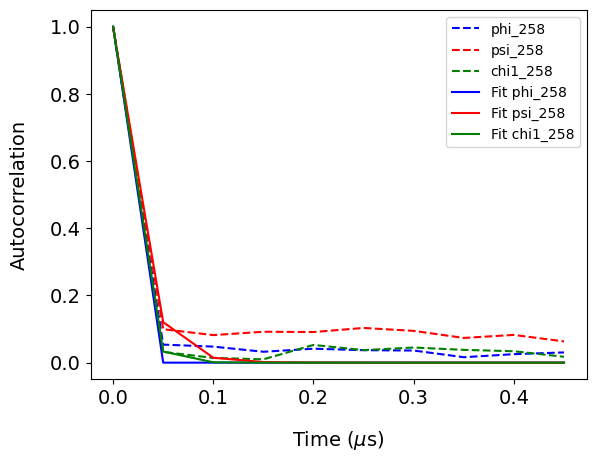

Correlation times:
phi_258: 0.0009161218600790902
psi_258: 0.02364784284998943
chi1_258: 0.0146544337247422


In [108]:
# Calculate autocorrelation for specific dihedral angles
phi258_acf = autocorr1(dihedral_dict['phi'][258], lags)
psi258_acf = autocorr1(dihedral_dict['psi'][258], lags)
chi258_acf = autocorr1(dihedral_dict['chi1'][258], lags)

# Fit exponential decay curve to autocorrelation data
popt_phi258, pcov_phi258 = curve_fit(exponential_decay, time[lags], phi258_acf)
popt_psi258, pcov_psi258 = curve_fit(exponential_decay, time[lags], psi258_acf)
popt_chi258, pcov_chi258 = curve_fit(exponential_decay, time[lags], chi258_acf)

# Plot autocorrelation functions against lag time
plt.plot(time[lags], phi258_acf, 'b--', label='phi_258')
plt.plot(time[lags], psi258_acf, 'r--', label='psi_258')
plt.plot(time[lags], chi258_acf, 'g--', label='chi1_258')

# Plot fitted curves
plt.plot(time[lags], exponential_decay(time[lags], *popt_phi258), 'b-', label='Fit phi_258')
plt.plot(time[lags], exponential_decay(time[lags], *popt_psi258), 'r-', label='Fit psi_258')
plt.plot(time[lags], exponential_decay(time[lags], *popt_chi258), 'g-', label='Fit chi1_258')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

# Extract correlation times from fitted parameters
tau_phi258 = popt_phi258[0]
tau_psi258 = popt_psi258[0]
tau_chi258 = popt_chi258[0]

print("Correlation times:")
print("phi_258:", tau_phi258)
print("psi_258:", tau_psi258)
print("chi1_258:", tau_chi258)


In [109]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define autocorrelation function
def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

# Generate time values
time = np.linspace(0, 300, trj.n_frames)

# Define lags for autocorrelation analysis
lags = range(10)

auto_corr_time_dict = {}
# Iterate over each residue in residues array
for angle in dihedral_dict.keys():
    for residue in dihedral_dict[angle].keys():
        # Calculate autocorrelation for each dihedral angle
        angle_acf = autocorr1(dihedral_dict[angle].get(residue, np.zeros(trj.n_frames)), lags)
    
        # Define a linear function for regression
        def linear_func(t, m, c):
            return m * t + c

        # Perform linear regression for each autocorrelation curve using the first two lag values
        linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])

        # Print the slopes
        print(f"Autocorrelation time for {angle} at residues {residue}: {-1/linfit_angle[0]}")
        if angle not in auto_corr_time_dict.keys(): \
            auto_corr_time_dict[angle]={}
        auto_corr_time_dict[angle][residue] = - 1/linfit_angle[0]
        

/var/folders/np/p_8hx6w53z9gtvwkrthry9x00000gn/T/ipykernel_8319/3524072629.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])


Autocorrelation time for phi at residues 2: 0.1285215715015264
Autocorrelation time for phi at residues 3: 0.10633816560603115
Autocorrelation time for phi at residues 4: 0.079282056028524
Autocorrelation time for phi at residues 5: 0.1267548464588717
Autocorrelation time for phi at residues 6: 0.8781156459879846
Autocorrelation time for phi at residues 7: 0.07670147943610196
Autocorrelation time for phi at residues 8: 0.12882681216568545
Autocorrelation time for phi at residues 9: 0.09597696783115282
Autocorrelation time for phi at residues 10: 0.2003317346726454
Autocorrelation time for phi at residues 11: 0.08641468691470015
Autocorrelation time for phi at residues 12: 0.11396769290447747
Autocorrelation time for phi at residues 13: 0.073301245933058
Autocorrelation time for phi at residues 14: 0.07210917458718527
Autocorrelation time for phi at residues 15: 0.05843670997209691
Autocorrelation time for phi at residues 16: 0.05435553525362805
Autocorrelation time for phi at residues 

In [110]:
dihedral_dict['phi'].keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

In [111]:
dihedral_dict['psi'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [112]:
dihedral_dict['chi1'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 2

In [113]:
dihedral_dict['chi2'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 29, 32, 33, 35, 37, 38, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 60, 61, 62, 63, 64, 65, 69, 70, 71, 72, 74, 75, 76, 79, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 94, 96, 98, 103, 104, 105, 107, 109, 110, 113, 115, 116, 119, 120, 122, 123, 125, 126, 127, 128, 129, 130, 132, 133, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 161, 162, 164, 165, 167, 168, 170, 171, 172, 173, 174, 176, 177, 178, 180, 182, 183, 185, 186, 187, 188, 191, 192, 194, 195, 196, 197, 198, 199, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 213, 214, 216, 219, 220, 221, 222, 223, 224, 226, 227, 228, 230, 231, 233, 234, 235, 237, 242, 243, 244, 245, 246, 247, 249, 250, 251, 253, 255, 256, 257, 258, 259, 261, 262, 263, 265])

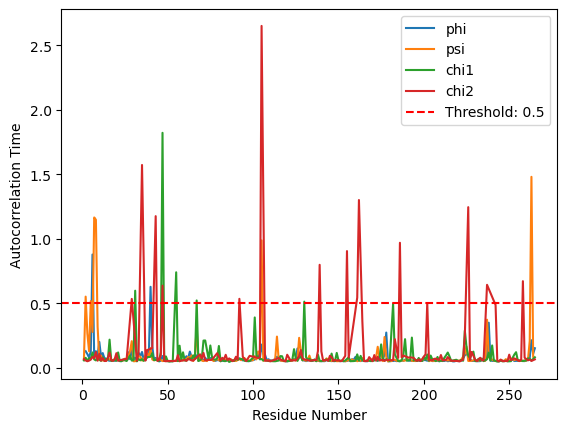

In [115]:
import matplotlib.pyplot as plt

#define threshold
threshold = 0.5

for angle in auto_corr_time_dict.keys():
    a_corr_arr = []
    residues = list(auto_corr_time_dict[angle].keys())
    for residue in residues:
        a_corr_arr.append(auto_corr_time_dict[angle][residue])
    plt.plot(residues, a_corr_arr, label=angle)

plt.legend()
plt.xlabel('Residue Number')  # Label for the x-axis
plt.ylabel('Autocorrelation Time')  # Label for the y-axis
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')  # Add a horizontal line for the threshold
plt.legend()
plt.show()


/var/folders/np/p_8hx6w53z9gtvwkrthry9x00000gn/T/ipykernel_8319/2101356961.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_, pcov_ = curve_fit(linear_regression, time[lags][:2], np.log(dihedral_acf[:2]))


Residue phi_6 has correlation time longer than 0.2 microseconds: 0.8528671371049319 microseconds.
Residue phi_40 has correlation time longer than 0.2 microseconds: 0.6023835215302877 microseconds.
Residue phi_178 has correlation time longer than 0.2 microseconds: 0.24713937106670586 microseconds.
Residue phi_238 has correlation time longer than 0.2 microseconds: 0.3238324068419377 microseconds.
Residue psi_2 has correlation time longer than 0.2 microseconds: 0.52620150464844 microseconds.
Residue psi_3 has correlation time longer than 0.2 microseconds: 0.23960148896812766 microseconds.
Residue psi_5 has correlation time longer than 0.2 microseconds: 0.4918190667153685 microseconds.
Residue psi_6 has correlation time longer than 0.2 microseconds: 0.25188420805831546 microseconds.
Residue psi_7 has correlation time longer than 0.2 microseconds: 1.1402108438147216 microseconds.
Residue psi_8 has correlation time longer than 0.2 microseconds: 1.1224035664356773 microseconds.
Residue psi_9 

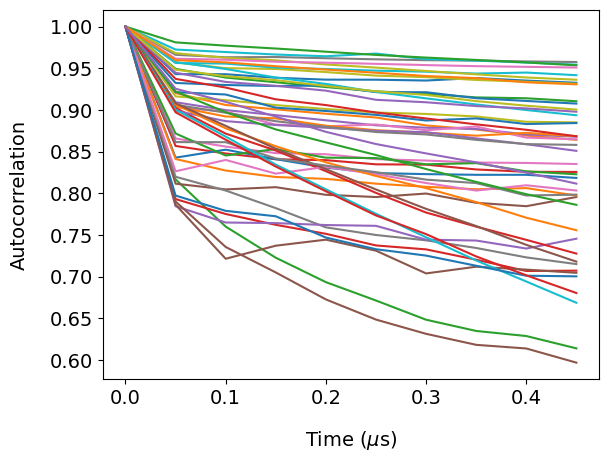

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define linear regression function
def linear_regression(x, m, c):
    return m * x + c

# Define your threshold value here (in microseconds)
threshold = 0.2

# List to store the residues with autocorrelation times greater than the threshold
residues_above_threshold = []

# Loop over all phi/psi/chi1/chi2 residues
for residue_type in ['phi', 'psi', 'chi1', 'chi2']:
    for residue_number, dihedral_data in dihedral_dict[residue_type].items():  
        # Calculate autocorrelation for each dihedral angle
        dihedral_acf = autocorr1(dihedral_data, lags)
        # Calculate correlation time (e.g., time for autocorrelation to decay to 0.1)
        correlation_time = 0
        if dihedral_acf[1] > 0: 
            popt_, pcov_ = curve_fit(linear_regression, time[lags][:2], np.log(dihedral_acf[:2]))
            correlation_time = -1/popt_[0]
            
            if correlation_time > threshold:
                residues_above_threshold.append((residue_type, residue_number, correlation_time))
                print(f"Residue {residue_type}_{residue_number} has correlation time longer than {threshold} microseconds: {correlation_time} microseconds.")

# Plotting only residues with correlation time greater than the threshold
for residue_type, residue_number, correlation_time in residues_above_threshold:
    dihedral_acf = autocorr1(dihedral_dict[residue_type][residue_number], lags)
    plt.plot(time[lags], dihedral_acf, label=f"{residue_type}_{residue_number}")

plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()


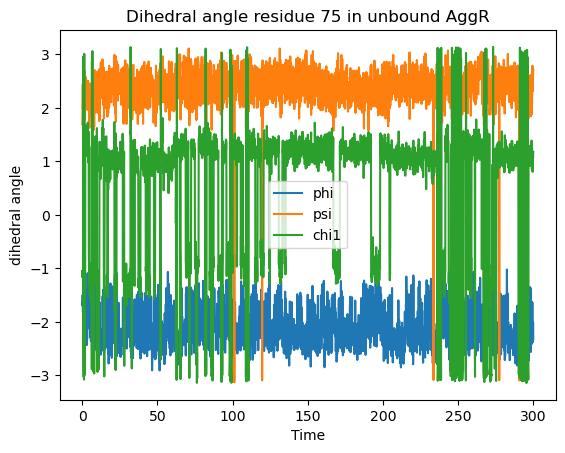

In [140]:
#oberservation of different conformations of dihedral angles that exist in residue 75
residue= 75
plt.plot(time[0:6000:2], dihedral_dict['phi'][75][0:6000:2], label='phi')
plt.plot(time[0:6000:2], dihedral_dict['psi'][75][0:6000:2], label='psi')
plt.plot(time[0:6000:2], dihedral_dict['chi1'][75][0:6000:2], label='chi1')

plt.legend()
plt.xlabel('Time')
plt.ylabel('dihedral angle')
plt.title('Dihedral angle residue 75 in unbound AggR')
plt.legend()
plt.show()

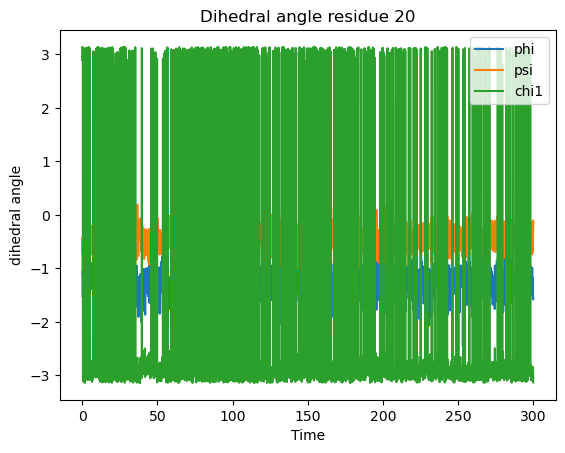

In [118]:
#forms a hydrogen bonds at two positions with the ligand
residue= 20
plt.plot(time[0:6000:2], dihedral_dict['phi'][20][0:6000:2], label='phi')
plt.plot(time[0:6000:2], dihedral_dict['psi'][20][0:6000:2], label='psi')
plt.plot(time[0:6000:2], dihedral_dict['chi1'][20][0:6000:2], label='chi1')

plt.legend()
plt.xlabel('Time')
plt.ylabel('dihedral angle')
plt.title('Dihedral angle residue 20')
plt.legend()
plt.show()

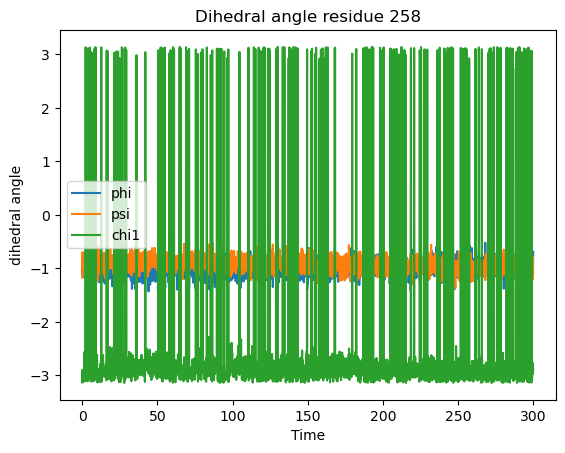

In [119]:
#forms hydrophobic interactions with the ligand
residue= 258
plt.plot(time[0:6000:2], dihedral_dict['phi'][258][0:6000:2], label='phi')
plt.plot(time[0:6000:2], dihedral_dict['psi'][258][0:6000:2], label='psi')
plt.plot(time[0:6000:2], dihedral_dict['chi1'][258][0:6000:2], label='chi1')

plt.legend()
plt.xlabel('Time')
plt.ylabel('dihedral angle')
plt.title('Dihedral angle residue 258')
plt.legend()
plt.show()

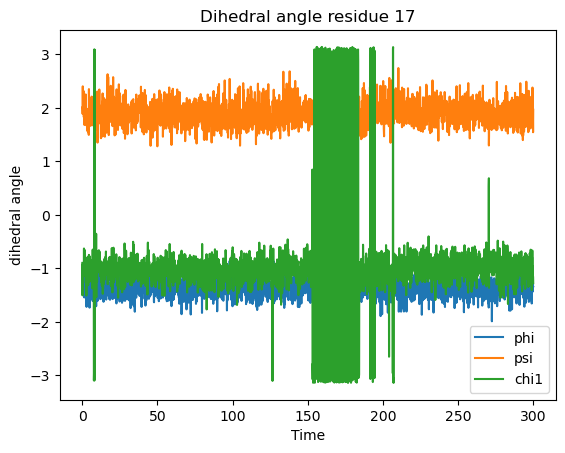

In [120]:
#forms hydrophobic interactions with the ligand
residue= 17
plt.plot(time[0:6000:2], dihedral_dict['phi'][17][0:6000:2], label='phi')
plt.plot(time[0:6000:2], dihedral_dict['psi'][17][0:6000:2], label='psi')
plt.plot(time[0:6000:2], dihedral_dict['chi1'][17][0:6000:2], label='chi1')

plt.legend()
plt.xlabel('Time')
plt.ylabel('dihedral angle')
plt.title('Dihedral angle residue 17')
plt.legend()
plt.show()

In [121]:
# 4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier.
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(phi,psi):
    cmean1=circular_mean(phi)
    cmean2=circular_mean(psi)
    numerator=(np.sum(np.sin(phi-cmean1)*np.sin(psi-cmean2)))
    denom=((np.sum(np.sin(phi-cmean1)**2)*np.sum(np.sin(psi-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [122]:
# Make correlation contact map
correlation_maps = []
for i in range(2, 265):
    cor_map = []
    for j in range(2, 265):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_cor_map)

(263, 263)

In [126]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:265]
#Lets Zero Out some of the Labels 
n=10
for i in range (0,264): 
  if (i % n !=0):
   seq_trunc[i]=''
print(seq_trunc)
print(sequence)

[LYS2, '', '', '', '', '', '', '', '', '', ILE12, '', '', '', '', '', '', '', '', '', TYR22, '', '', '', '', '', '', '', '', '', ILE32, '', '', '', '', '', '', '', '', '', THR42, '', '', '', '', '', '', '', '', '', GLU52, '', '', '', '', '', '', '', '', '', GLN62, '', '', '', '', '', '', '', '', '', ILE72, '', '', '', '', '', '', '', '', '', ARG82, '', '', '', '', '', '', '', '', '', TYR92, '', '', '', '', '', '', '', '', '', CYS102, '', '', '', '', '', '', '', '', '', ALA112, '', '', '', '', '', '', '', '', '', PHE122, '', '', '', '', '', '', '', '', '', ARG132, '', '', '', '', '', '', '', '', '', SER142, '', '', '', '', '', '', '', '', '', GLU152, '', '', '', '', '', '', '', '', '', PHE162, '', '', '', '', '', '', '', '', '', LYS172, '', '', '', '', '', '', '', '', '', ILE182, '', '', '', '', '', '', '', '', '', ILE192, '', '', '', '', '', '', '', '', '', TYR202, '', '', '', '', '', '', '', '', '', SER212, '', '', '', '', '', '', '', '', '', LEU222, '', '', '', '', '', '', '', '', ''

In [127]:
#Q5Make a 2D map showing the populations of hydrogen bonds between different residues.

hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))

LEU3-N -- LYS9-O
GLN5-N -- GLN5-OE1
ILE7-N -- LYS4-O
GLU8-N -- LYS4-O
LYS9-N -- GLU8-OE2
GLU10-N -- LYS63-O
ILE11-N -- MET1-O
ILE12-N -- LEU61-O
ILE14-N -- VAL59-O
ASN15-N -- PHE251-O
ASN15-ND2 -- PHE251-O
ASN16-N -- SER58-OG
ASN16-ND2 -- HIS250-O
ILE17-N -- ILE57-O
ILE19-N -- ILE55-O
HIS20-N -- ARG18-O
HIS20-NE2 -- GLU171-OE1
HIS20-NE2 -- GLU171-OE2
GLN21-NE2 -- LEU76-O
THR23-N -- LEU51-O
VAL24-N -- ILE74-O
LEU25-N -- ILE49-O
TYR26-N -- ILE72-O
THR27-N -- GLU47-O
SER28-N -- TYR26-O
ASN29-N -- SER28-OG
ASN29-N -- PRO70-O
ASN29-ND2 -- LYS65-O
ASN29-ND2 -- VAL68-O
ASN29-ND2 -- ASN69-O
CYS30-N -- PRO70-O
THR31-N -- GLN62-O
ILE32-N -- LEU44-O
ASP33-N -- ARG60-O
VAL34-N -- THR42-O
TYR35-N -- SER58-O
THR36-N -- SER40-O
THR36-N -- ASN41-OD1
GLU38-N -- THR36-OG1
GLU38-N -- GLU38-OE1
GLU38-N -- GLU38-OE2
GLY39-N -- THR36-OG1
GLY39-N -- THR36-O
SER40-N -- THR36-OG1
SER40-N -- GLU38-OE1
SER40-N -- GLU38-OE2
ASN41-N -- GLY39-O
ASN41-ND2 -- ASP33-OD1
ASN41-ND2 -- THR36-O
ASN41-ND2 -- VAL34-O
THR42-

In [128]:
np.shape(hbonds)

(414, 3)

In [129]:

for hbond in hbonds:
 donor = top.atom(hbond[0])
 acc = top.atom(hbond[2])
 print(hbond,donor,acc)

[ 41  42 168] LEU3-N LYS9-O
[82 83 93] GLN5-N GLN5-OE1
[113 114  81] ILE7-N LYS4-O
[132 133  81] GLU8-N LYS4-O
[147 148 144] LYS9-N GLU8-OE2
[ 169  170 1083] GLU10-N LYS63-O
[184 185  18] ILE11-N MET1-O
[ 203  204 1044] ILE12-N LEU61-O
[ 244  245 1001] ILE14-N VAL59-O
[ 263  264 4152] ASN15-N PHE251-O
[ 272  274 4152] ASN15-ND2 PHE251-O
[277 278 982] ASN16-N SER58-OG
[ 286  288 4132] ASN16-ND2 HIS250-O
[291 292 974] ILE17-N ILE57-O
[334 335 941] ILE19-N ILE55-O
[353 354 333] HIS20-N ARG18-O
[ 364  365 2807] HIS20-NE2 GLU171-OE1
[ 364  365 2808] HIS20-NE2 GLU171-OE2
[ 382  384 1307] GLN21-NE2 LEU76-O
[408 409 876] THR23-N LEU51-O
[ 422  423 1264] VAL24-N ILE74-O
[438 439 837] LEU25-N ILE49-O
[ 457  458 1235] TYR26-N ILE72-O
[478 479 799] THR27-N GLU47-O
[492 493 477] SER28-N TYR26-O
[503 504 499] ASN29-N SER28-OG
[ 503  504 1196] ASN29-N PRO70-O
[ 512  513 1127] ASN29-ND2 LYS65-O
[ 512  514 1168] ASN29-ND2 VAL68-O
[ 512  514 1182] ASN29-ND2 ASN69-O
[ 517  518 1196] CYS30-N PRO70-O
[ 528

In [130]:

# Assuming trj is properly defined before this point
# trj = ...

# Get the number of residues
num_residues = trj.n_residues

# Get the number of frames
frames = range(trj.n_frames)

# Initialize a square matrix to store the count of hydrogen bonds for each residue
hbond_population_matrix = np.zeros((num_residues, num_residues), dtype=int)

# Iterate over each frame
for frame in frames:
    # Calculate the hydrogen bonds for the current frame
    hbonds = md.baker_hubbard(trj[frame], periodic=False)
    
    # Iterate over each hydrogen bond in the current frame
    for hbond in hbonds:
        # Get the donor and acceptor atoms
        donor_index = hbond[0]
        acceptor_index = hbond[2]
        
        # Initialize variables to store donor and acceptor residues
        donor_residue = None
        acceptor_residue = None
        
        # Iterate over each residue to find the donor and acceptor residues
        for residue in trj.topology.residues:
            # Check if the donor atom belongs to this residue
            if donor_index in [atom.index for atom in residue.atoms]:
                donor_residue = residue.index
                
            # Check if the acceptor atom belongs to this residue
            if acceptor_index in [atom.index for atom in residue.atoms]:
                acceptor_residue = residue.index

        # Increment the count in the matrix if both donor and acceptor residues are found
        if donor_residue is not None and acceptor_residue is not None:
            hbond_population_matrix[donor_residue, acceptor_residue] += 1
            hbond_population_matrix[acceptor_residue, donor_residue] += 1

# Print the hydrogen bond matrix
print(hbond_population_matrix)

print(donor_index)
print(acceptor_index)
print(donor_residue)
print(acceptor_residue)
print(frames)

[[   4    0   32 ...    0    0    0]
 [   0    2   45 ...    0    0    0]
 [  32   45    0 ...    0    0    0]
 ...
 [   0    0    0 ...   14  163 2205]
 [   0    0    0 ...  163   54  378]
 [   0    0    0 ... 2205  378  508]]
4312
1044
260
60
range(0, 6000)


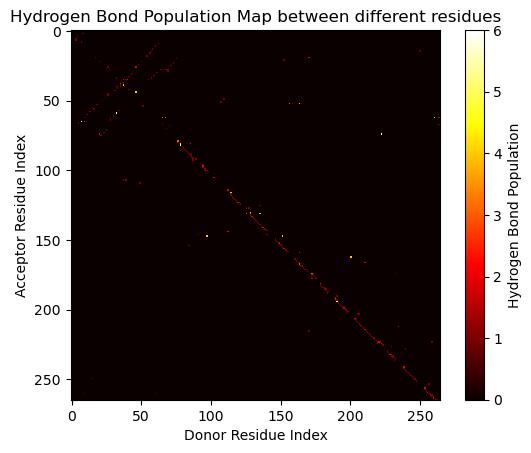

In [131]:
def calculate_hbond_population(trj):
    hbond_populations = np.zeros((trj.topology.n_residues, trj.topology.n_residues), dtype=int)
    for hbond in md.baker_hubbard(trj, periodic=False):
        donor_residue = trj.topology.atom(hbond[0]).residue.index
        acceptor_residue = trj.topology.atom(hbond[2]).residue.index
        hbond_populations[donor_residue, acceptor_residue] += 1
    return hbond_populations

def plot_hbond_map(hbond_populations):
    plt.imshow(hbond_populations, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Hydrogen Bond Population')
    plt.xlabel('Donor Residue Index')
    plt.ylabel('Acceptor Residue Index')
    plt.title('Hydrogen Bond Population Map between different residues')
    plt.show()
    #plt.invert_yaxis()

# Calculate hydrogen bond populations
hbond_populations = calculate_hbond_population(trj)

# Plot the hydrogen bond map
plot_hbond_map(hbond_populations)

In [132]:
print(hbond_populations)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


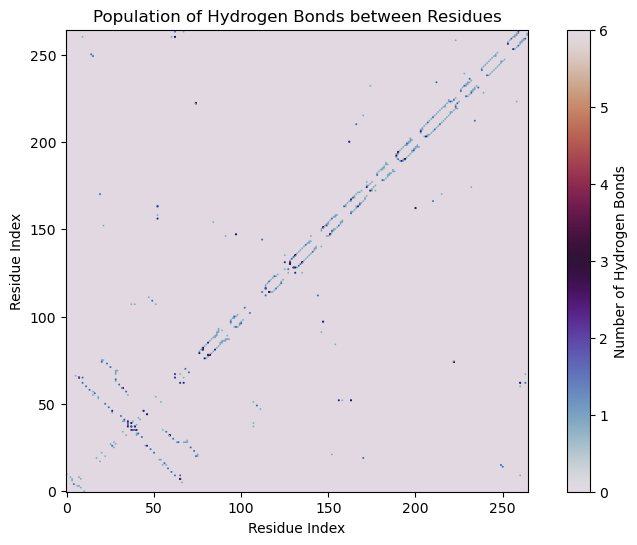

In [133]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

# Calculate hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)

# Get the maximum residue index
max_residue_index = max(trj.topology.residue(i).index for i in range(trj.n_residues)) + 1

# Initialize a matrix to store the count of hydrogen bonds for each residue
residue_hbond_count = np.zeros((max_residue_index, max_residue_index))

# Loop through each hydrogen bond
for hbond in hbonds:
    # Get the indices of the atoms involved in the hydrogen bond
    donor_index = hbond[0]
    acceptor_index = hbond[2]
    
    # Get the residue indices of the donor and acceptor atoms
    donor_residue_index = trj.topology.atom(donor_index).residue.index
    acceptor_residue_index = trj.topology.atom(acceptor_index).residue.index
    
    # Increment the count for the donor and acceptor residues
    residue_hbond_count[donor_residue_index, acceptor_residue_index] += 1
    residue_hbond_count[acceptor_residue_index, donor_residue_index] += 1

# Plotting 2D colormap
plt.figure(figsize=(10, 6))
plt.imshow(residue_hbond_count, cmap='twilight', origin='lower')
plt.colorbar(label='Number of Hydrogen Bonds')
plt.xlabel('Residue Index')
plt.ylabel('Residue Index')
plt.title('Population of Hydrogen Bonds between Residues')
plt.grid(False)
plt.show()


In [134]:
import pyblock
from itertools import chain
def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error

In [135]:
def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out
def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr

/var/folders/np/p_8hx6w53z9gtvwkrthry9x00000gn/T/ipykernel_8319/2536349802.py:30: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)
/opt/anaconda3/envs/AggR_apo_MD/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AggR_apo_MD/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


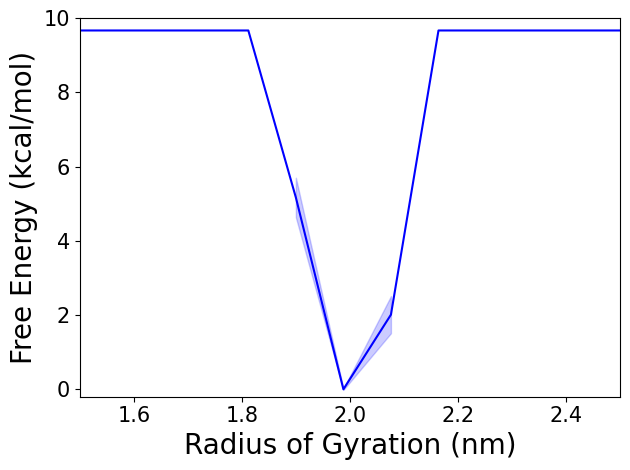

In [136]:
dG, bin_centers, ferr = free_energy_1D_blockerror(rg, 300, 0.8, 3.0, 25, 5)
sns.lineplot(x=bin_centers, y=dG, color='blue')
plt.fill_between(bin_centers, dG-ferr, dG+ferr, color='blue', alpha=0.2)
plt.ylim(-0.2, 10)
plt.xlim(1.5, 2.5)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
np.savetxt(outdir+ 'AggR_apo_rg.dG.err.dat', np.column_stack((bin_centers, dG, ferr)))
plt.tight_layout()
plt.savefig('%s/Rg.dG.pdf' % outdir)
plt.show()